# DA11 Preprocess
01/30/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'DA11'
subj_format = ['nlx']
subj_site = ['UCD']


# Make mne_data


### DA11 channels are split into 3 equal ncs files - need to load + join

### Load and resample data


In [7]:
load_path = f'{neural_dir}{subj_id}/raw_nlx/'

In [10]:
ncs_files = glob(f'{load_path}/*.ncs')
ncs_files

['/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/RFP1_0005.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LAM6_0006.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/RIA9_0005.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LAM1_0006.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LAM2_0007.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LTT2_0005.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/RHH2_0006.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LHH1_0006.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/Photodiode_0005.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LHB6_0006.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/RSM6_0005.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA1

In [11]:
ncs_files.sort() ### added to make channels in alphabetical order 

In [12]:
### empty vecs to load data into 

signals = [] #data
srs = [] #sampling rate
ch_name = [] #channel name
ch_type = [] #channel type (seeg, eeg etc.)

In [13]:
ch_names = []

for chan_path in ncs_files:
    chan_name = chan_path.split('/')[-1].replace('.ncs','')
    # strip the file type off the end if needed 
    if '_' in chan_name:
        chan_name = chan_name.split('_')[0]
    ch_names.append(chan_name)

ch_file_dict = {} #dictionary mapping electrode name to the its 2 corresponding data files 

for ch in ch_names:
    ch_files = [f for f in ncs_files if ch == f.split('/')[-1].replace('.ncs','').split('_')[0]] #was saving ch 10 with ch 1 before
    ch_file_dict[ch]=ch_files
    
ch_file_dict


{'LAM1': ['/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LAM1_0005.ncs',
  '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LAM1_0006.ncs',
  '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LAM1_0007.ncs'],
 'LAM2': ['/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LAM2_0005.ncs',
  '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LAM2_0006.ncs',
  '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LAM2_0007.ncs'],
 'LAM3': ['/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LAM3_0005.ncs',
  '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LAM3_0006.ncs',
  '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LAM3_0007.ncs'],
 'LAM4': ['/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LAM4_0005.ncs',
  '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_nlx/LAM4_0006.ncs',
  '/sc/arion/projec

In [14]:
ch_file_counts = {}

for ch in ch_file_dict:
    ch_file_counts[ch] = len(ch_file_dict[ch])
    
ch_file_counts

{'LAM1': 3,
 'LAM2': 3,
 'LAM3': 3,
 'LAM4': 3,
 'LAM5': 3,
 'LAM6': 3,
 'LAM7': 3,
 'LAM8': 3,
 'LAM9': 3,
 'LHB1': 3,
 'LHB2': 3,
 'LHB3': 3,
 'LHB4': 3,
 'LHB5': 3,
 'LHB6': 3,
 'LHB7': 3,
 'LHB8': 3,
 'LHB9': 3,
 'LHH1': 3,
 'LHH2': 3,
 'LHH3': 3,
 'LHH4': 3,
 'LHH5': 3,
 'LHH6': 3,
 'LHH7': 3,
 'LHH8': 3,
 'LHH9': 3,
 'LTT1': 3,
 'LTT2': 3,
 'LTT3': 3,
 'LTT4': 3,
 'LTT5': 3,
 'LTT6': 3,
 'LTT7': 3,
 'LTT8': 3,
 'LTT9': 3,
 'Photodiode': 3,
 'RAC10': 3,
 'RAC1': 3,
 'RAC2': 3,
 'RAC3': 3,
 'RAC4': 3,
 'RAC5': 3,
 'RAC6': 3,
 'RAC7': 3,
 'RAC8': 3,
 'RAC9': 3,
 'RAM1': 3,
 'RAM2': 3,
 'RAM3': 3,
 'RAM4': 3,
 'RAM5': 3,
 'RAM6': 3,
 'RAM7': 3,
 'RAM8': 3,
 'RAM9': 3,
 'RFP1': 3,
 'RFP2': 3,
 'RFP3': 3,
 'RFP4': 3,
 'RFP5': 3,
 'RFP6': 3,
 'RFP7': 3,
 'RFP8': 3,
 'RFP9': 3,
 'RHB1': 3,
 'RHB2': 3,
 'RHB3': 3,
 'RHB4': 3,
 'RHB5': 3,
 'RHB6': 3,
 'RHB7': 3,
 'RHB8': 3,
 'RHB9': 3,
 'RHH1': 3,
 'RHH2': 3,
 'RHH3': 3,
 'RHH4': 3,
 'RHH5': 3,
 'RHH6': 3,
 'RHH7': 3,
 'RHH8': 3,
 'RHH9': 

In [15]:
### empty vecs to load data into 

ch_name = [] #channel name
srs = [] #sampling rate
signals = [] #data
ch_type = []

In [16]:
#### add data and sampling rate to signals, srs, ch_name 

# make concatenated dictionaries for each channel 
#load nlx files for each channel
#make new dict with info and data for each channel
#make sure to join data in correct order (should be _0005 then _0007)

ch_data_dict = {}
ch_time_dict = {}

for ch in ch_file_dict:

    #load ncs files for the channel
    file1 = nlx_utils.load_ncs(ch_file_dict[ch][0])
    file2 = nlx_utils.load_ncs(ch_file_dict[ch][1])
    file3 = nlx_utils.load_ncs(ch_file_dict[ch][2])
    files_list = [file1,file2,file3]
    start_times = [file1['time'][0],file2['time'][0],file3['time'][0]] 
    first_idx = np.argmin(start_times) #for this patient I can remove earliest file because I verified that this was the file that needed to be removed 
    first_file = files_list[first_idx]
    last_idx = np.argmax(start_times)
    third_file = files_list[last_idx]
    middle_idx = [n for n in range(3) if (n!=first_idx) & (n!=last_idx)][0]
    second_file = files_list[middle_idx]

#     #load ncs files for the channel
#     file1 = nlx_utils.load_ncs(ch_file_dict[ch][0])
#     file2 = nlx_utils.load_ncs(ch_file_dict[ch][1])
#     #check which file comes first - time between files should be shorter if order is correct
#     if (file1['time'][0] - file2['time'][-1]) > (file2['time'][0] - file1['time'][-1]): #if first difference larger - file 1 comes first, if second difference is larger file 2 comes first 
#         first_file = file1
#         second_file = file2
#     elif (file1['time'][0] - file2['time'][-1]) < (file2['time'][0] - file1['time'][-1]):
#             first_file = file2
#             second_file = file1
#     else:
#         print('cannot identify file order for ',ch)

    #concatenate data and timestamps from each channel
    data_array = np.hstack((first_file['data'],second_file['data'],third_file['data']))
    time_array = np.hstack((first_file['time'],second_file['time'],third_file['time']))
    #save into dictionaries (just in case this is needed again or needs to be checked)
    ch_data_dict[ch] = data_array
    ch_time_dict[ch] = time_array
    samp_rate = first_file['sampling_rate']
    #add ch info, samp rate, and concatenated data array to master list
    ch_name.append(ch)
    srs.append(samp_rate)
    signals.append(data_array)
    if ch == 'Photodiode':
        ch_type.append('stim')
    else:
        ch_type.append('seeg')

    
    
    
    

In [17]:
for ch,s in list(zip(ch_name,signals)):
    print(ch,s.shape)

LAM1 (20877824,)
LAM2 (20877824,)
LAM3 (20877824,)
LAM4 (20877824,)
LAM5 (20877824,)
LAM6 (20877824,)
LAM7 (20877824,)
LAM8 (20877824,)
LAM9 (20877824,)
LHB1 (20877824,)
LHB2 (20877824,)
LHB3 (20877824,)
LHB4 (20877824,)
LHB5 (20877824,)
LHB6 (20877824,)
LHB7 (20877824,)
LHB8 (20877824,)
LHB9 (20877824,)
LHH1 (20877824,)
LHH2 (20877824,)
LHH3 (20877824,)
LHH4 (20877824,)
LHH5 (20877824,)
LHH6 (20877824,)
LHH7 (20877824,)
LHH8 (20877824,)
LHH9 (20877824,)
LTT1 (20877824,)
LTT2 (20877824,)
LTT3 (20877824,)
LTT4 (20877824,)
LTT5 (20877824,)
LTT6 (20877824,)
LTT7 (20877824,)
LTT8 (20877824,)
LTT9 (20877824,)
Photodiode (20877824,)
RAC10 (20877824,)
RAC1 (20877824,)
RAC2 (20877824,)
RAC3 (20877824,)
RAC4 (20877824,)
RAC5 (20877824,)
RAC6 (20877824,)
RAC7 (20877824,)
RAC8 (20877824,)
RAC9 (20877824,)
RAM1 (20877824,)
RAM2 (20877824,)
RAM3 (20877824,)
RAM4 (20877824,)
RAM5 (20877824,)
RAM6 (20877824,)
RAM7 (20877824,)
RAM8 (20877824,)
RAM9 (20877824,)
RFP1 (20877824,)
RFP2 (20877824,)
RFP3 (2

In [18]:
#save dictionary of channel > data mappings 
import pickle 

dict_save_path = f'{neural_dir}{subj_id}/'

# create a binary pickle file 
f = open(f'{dict_save_path}concat_data.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(ch_data_dict,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{dict_save_path}concat_time.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(ch_time_dict,f)
# # close file
f.close()


In [19]:
target_sr = 500 #downsampling to 500 to be consistent with other data - alternative = np.min(srs)
mne_data_resampled = []

In [20]:
### resampling to 500Hz

for sr in np.unique(srs):
    ch_ix = np.where(srs==sr)[0].astype(int)
    info = mne.create_info([x for ix, x in enumerate(ch_name) if ix in ch_ix], sr)
    mne_data_temp = mne.io.RawArray([x for ix, x in enumerate(signals) if ix in ch_ix], info)
    if sr != target_sr:
        # resample down to one sample rate 
        mne_data_temp.resample(sfreq=target_sr, npad='auto', n_jobs=-1)
        mne_data_resampled.append(mne_data_temp)
    else: 
        mne_data = mne_data_temp
        

Creating RawArray with float64 data, n_channels=119, n_times=20877824
    Range : 0 ... 20877823 =      0.000 ...  5219.456 secs
Ready.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 119 out of 119 | elapsed:  3.7min finished


In [22]:
### make sure timing is aligned post resampling 

#Because of the resampling, the end timings might not match perfectly:https://github.com/mne-tools/mne-python/issues/8257

if mne_data_resampled[0].tmax > mne_data_temp.tmax:
    mne_data_resampled[0].crop(tmin=0, tmax=mne_data_temp.tmax)
elif mne_data_resampled[0].tmax < mne_data_temp.tmax:
    mne_data_temp.crop(tmin=0, tmax=mne_data_resampled[0].tmax)
    

In [23]:
mne_data = mne_data_resampled[0]  #mne_data.add_channels([mne_data_temp]) to add more channels input mne object as list
mne_data

<RawArray | 119 x 2609728 (5219.5 s), ~2.31 GB, data loaded>

In [24]:
ch_name

['LAM1',
 'LAM2',
 'LAM3',
 'LAM4',
 'LAM5',
 'LAM6',
 'LAM7',
 'LAM8',
 'LAM9',
 'LHB1',
 'LHB2',
 'LHB3',
 'LHB4',
 'LHB5',
 'LHB6',
 'LHB7',
 'LHB8',
 'LHB9',
 'LHH1',
 'LHH2',
 'LHH3',
 'LHH4',
 'LHH5',
 'LHH6',
 'LHH7',
 'LHH8',
 'LHH9',
 'LTT1',
 'LTT2',
 'LTT3',
 'LTT4',
 'LTT5',
 'LTT6',
 'LTT7',
 'LTT8',
 'LTT9',
 'Photodiode',
 'RAC10',
 'RAC1',
 'RAC2',
 'RAC3',
 'RAC4',
 'RAC5',
 'RAC6',
 'RAC7',
 'RAC8',
 'RAC9',
 'RAM1',
 'RAM2',
 'RAM3',
 'RAM4',
 'RAM5',
 'RAM6',
 'RAM7',
 'RAM8',
 'RAM9',
 'RFP1',
 'RFP2',
 'RFP3',
 'RFP4',
 'RFP5',
 'RFP6',
 'RFP7',
 'RFP8',
 'RFP9',
 'RHB1',
 'RHB2',
 'RHB3',
 'RHB4',
 'RHB5',
 'RHB6',
 'RHB7',
 'RHB8',
 'RHB9',
 'RHH1',
 'RHH2',
 'RHH3',
 'RHH4',
 'RHH5',
 'RHH6',
 'RHH7',
 'RHH8',
 'RHH9',
 'RIA10',
 'RIA1',
 'RIA2',
 'RIA3',
 'RIA4',
 'RIA5',
 'RIA6',
 'RIA7',
 'RIA8',
 'RIA9',
 'RIP10',
 'RIP1',
 'RIP2',
 'RIP3',
 'RIP4',
 'RIP5',
 'RIP6',
 'RIP7',
 'RIP8',
 'RIP9',
 'RSM1',
 'RSM2',
 'RSM3',
 'RSM4',
 'RSM5',
 'RSM6',
 'RTT10',


In [25]:
srs

[4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000,
 4000]

In [26]:
mne_data_resampled[0]

<RawArray | 119 x 2609728 (5219.5 s), ~2.31 GB, data loaded>

In [27]:
mne_data = mne_data_resampled[0]  #mne_data.add_channels([mne_data_temp]) to add more channels input mne object as list
# mne_data.add_channels([mne_data_resampled[1]])
mne_data

<RawArray | 119 x 2609728 (5219.5 s), ~2.31 GB, data loaded>

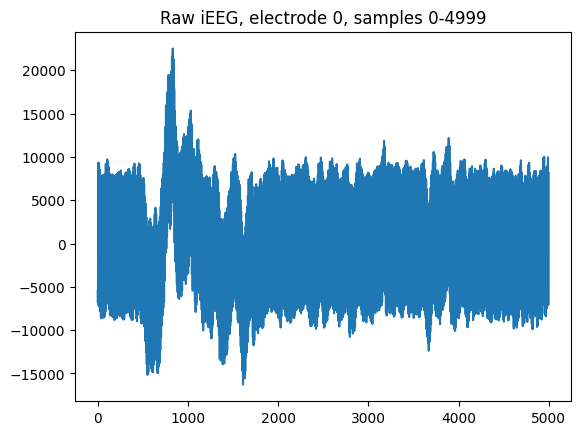

In [28]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Photodiode
- examine photodiode 

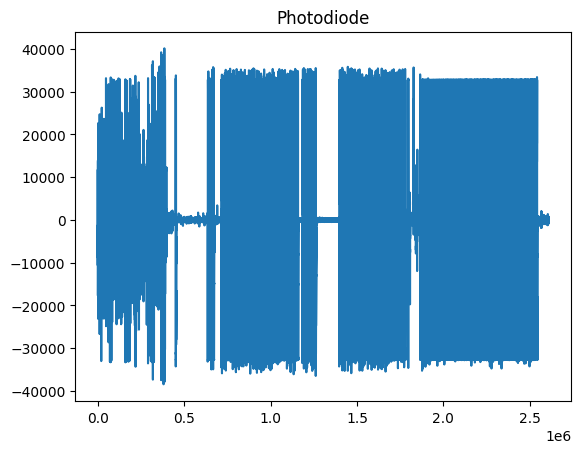

In [29]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("Photodiode")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [30]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='Photodiode', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/photodiode.fif
[done]


In [31]:
mne_data.drop_channels(['Photodiode'])

<RawArray | 118 x 2609728 (5219.5 s), ~2.29 GB, data loaded>

### Notch filter line noise

In [32]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240),picks = mne_data.ch_names)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:   12.3s finished


<RawArray | 118 x 2609728 (5219.5 s), ~2.29 GB, data loaded>

### Anatomical Localization

In [33]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawArray | 118 x 2609728 (5219.5 s), ~2.29 GB, data loaded>

In [34]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination
0,LAM1,rHipp_L,-23.583114,13.677539,-14.846665,-21.787677,-3.071038,-27.563982,Gray,Left Amygdala,Amygdala (LB),L ParaHippocampal Gyrus,L Hipp,Left amygdala inferior,NaN
1,LAM2,lAmyg_L,-28.379682,12.878366,-14.846665,-26.646692,-4.016142,-27.115331,Gray,Left Amygdala,Amygdala (LB),L ParaHippocampal Gyrus,L Amyg,Left amygdala inferior,NaN
2,LAM3,lAmyg_L,-33.176250,12.079194,-14.846665,-31.485298,-4.962499,-26.790415,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Amyg,Left amygdala inferior,NaN
3,LAM4,A20rv_L,-37.972818,11.280022,-15.246466,-36.333955,-5.878473,-26.979067,White,Left Cerebral White Matter,Unknown,L Fusiform Gyrus,L FuG,Unknown,OOB
4,LAM5,A20rv_L,-42.769386,10.081264,-15.246466,-41.307728,-7.013807,-26.690822,White,Left Cerebral White Matter,Unknown,L Inferior Temporal Gyrus,L FuG,Unknown,WM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,RTT5,A20r_R,36.773699,19.271744,-22.442895,39.412887,0.344354,-36.125057,White,Right ITG inferior temporal gyrus,Unknown,R Inferior Temporal Gyrus,R ITG,Right inferior temporal pole C,WM
114,RTT6,A20iv_R,39.571697,14.876297,-21.643292,42.026220,-3.612829,-33.797227,White,Right Cerebral White Matter,Unknown,R Inferior Temporal Gyrus,R ITG,Unknown,WM
115,RTT7,A20iv_R,41.969981,10.880436,-21.243491,44.290563,-7.278455,-32.029983,White,Right Cerebral White Matter,Unknown,R Inferior Temporal Gyrus,R ITG,Right basal inferior temporal gyrus A,NaN
116,RTT8,A20iv_R,44.767979,6.484989,-20.443887,47.091041,-11.128435,-29.650420,White,Right Cerebral White Matter,Unknown,R Inferior Temporal Gyrus,R ITG,Unknown,WM


In [35]:
list(elec_locs.label)

['LAM1',
 'LAM2',
 'LAM3',
 'LAM4',
 'LAM5',
 'LAM6',
 'LAM7',
 'LAM8',
 'LAM9',
 'LHB1',
 'LHB2',
 'LHB3',
 'LHB4',
 'LHB5',
 'LHB6',
 'LHB7',
 'LHB8',
 'LHB9',
 'LHH1',
 'LHH2',
 'LHH3',
 'LHH4',
 'LHH5',
 'LHH6',
 'LHH7',
 'LHH8',
 'LHH9',
 'LTT1',
 'LTT2',
 'LTT3',
 'LTT4',
 'LTT5',
 'LTT6',
 'LTT7',
 'LTT8',
 'LTT9',
 'RAC1',
 'RAC10',
 'RAC2',
 'RAC3',
 'RAC4',
 'RAC5',
 'RAC6',
 'RAC7',
 'RAC8',
 'RAC9',
 'RAM1',
 'RAM2',
 'RAM3',
 'RAM4',
 'RAM5',
 'RAM6',
 'RAM7',
 'RAM8',
 'RAM9',
 'RFP1',
 'RFP2',
 'RFP3',
 'RFP4',
 'RFP5',
 'RFP6',
 'RFP7',
 'RFP8',
 'RFP9',
 'RHB1',
 'RHB2',
 'RHB3',
 'RHB4',
 'RHB5',
 'RHB6',
 'RHB7',
 'RHB8',
 'RHB9',
 'RHH1',
 'RHH2',
 'RHH3',
 'RHH4',
 'RHH5',
 'RHH6',
 'RHH7',
 'RHH8',
 'RHH9',
 'RIA1',
 'RIA10',
 'RIA2',
 'RIA3',
 'RIA4',
 'RIA5',
 'RIA6',
 'RIA7',
 'RIA8',
 'RIA9',
 'RIP1',
 'RIP10',
 'RIP2',
 'RIP3',
 'RIP4',
 'RIP5',
 'RIP6',
 'RIP7',
 'RIP8',
 'RIP9',
 'RSM1',
 'RSM2',
 'RSM3',
 'RSM4',
 'RSM5',
 'RSM6',
 'RTT1',
 'RTT10',
 'RTT2

In [36]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

[]


In [37]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


In [38]:
unmatched_seeg #make sure there are no unmatched names


[]

In [39]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [40]:
new_name_dict #make sure this passes the eye test 


{'lam1': 'lam1',
 'lam2': 'lam2',
 'lam3': 'lam3',
 'lam4': 'lam4',
 'lam5': 'lam5',
 'lam6': 'lam6',
 'lam7': 'lam7',
 'lam8': 'lam8',
 'lam9': 'lam9',
 'lhb1': 'lhb1',
 'lhb2': 'lhb2',
 'lhb3': 'lhb3',
 'lhb4': 'lhb4',
 'lhb5': 'lhb5',
 'lhb6': 'lhb6',
 'lhb7': 'lhb7',
 'lhb8': 'lhb8',
 'lhb9': 'lhb9',
 'lhh1': 'lhh1',
 'lhh2': 'lhh2',
 'lhh3': 'lhh3',
 'lhh4': 'lhh4',
 'lhh5': 'lhh5',
 'lhh6': 'lhh6',
 'lhh7': 'lhh7',
 'lhh8': 'lhh8',
 'lhh9': 'lhh9',
 'ltt1': 'ltt1',
 'ltt2': 'ltt2',
 'ltt3': 'ltt3',
 'ltt4': 'ltt4',
 'ltt5': 'ltt5',
 'ltt6': 'ltt6',
 'ltt7': 'ltt7',
 'ltt8': 'ltt8',
 'ltt9': 'ltt9',
 'rac10': 'rac10',
 'rac1': 'rac1',
 'rac2': 'rac2',
 'rac3': 'rac3',
 'rac4': 'rac4',
 'rac5': 'rac5',
 'rac6': 'rac6',
 'rac7': 'rac7',
 'rac8': 'rac8',
 'rac9': 'rac9',
 'ram1': 'ram1',
 'ram2': 'ram2',
 'ram3': 'ram3',
 'ram4': 'ram4',
 'ram5': 'ram5',
 'ram6': 'ram6',
 'ram7': 'ram7',
 'ram8': 'ram8',
 'ram9': 'ram9',
 'rfp1': 'rfp1',
 'rfp2': 'rfp2',
 'rfp3': 'rfp3',
 'rfp4': 'rf

In [41]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawArray | 118 x 2609728 (5219.5 s), ~2.29 GB, data loaded>

In [42]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 36 left sEEG and 82 right sEEG electrodes
We have a total of 118 sEEG electrodes


In [43]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawArray | 118 x 2609728 (5219.5 s), ~2.29 GB, data loaded>

In [44]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawArray | 118 x 2609728 (5219.5 s), ~2.29 GB, data loaded>

In [45]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawArray | 118 x 2609728 (5219.5 s), ~2.29 GB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [46]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [47]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [48]:
probe_ch_counts

{'lam': 9,
 'lhb': 9,
 'lhh': 9,
 'ltt': 9,
 'rac': 10,
 'ram': 9,
 'rfp': 9,
 'rhb': 9,
 'rhh': 9,
 'ria': 10,
 'rip': 10,
 'rsm': 6,
 'rtt': 10}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [59]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) # good for this patient

['rac3', 'rac6', 'rfp1', 'rsm4']

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


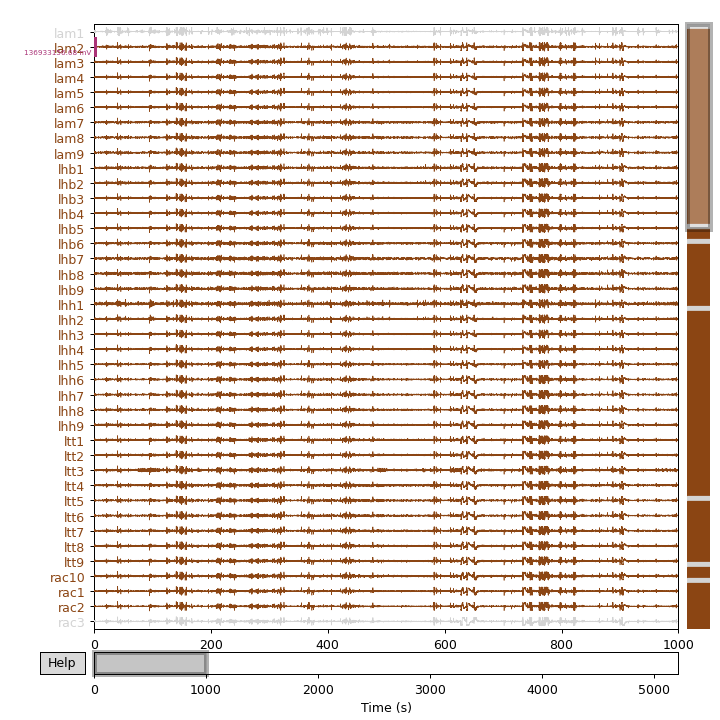

In [50]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=40, scalings=mne_data._data.max())


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


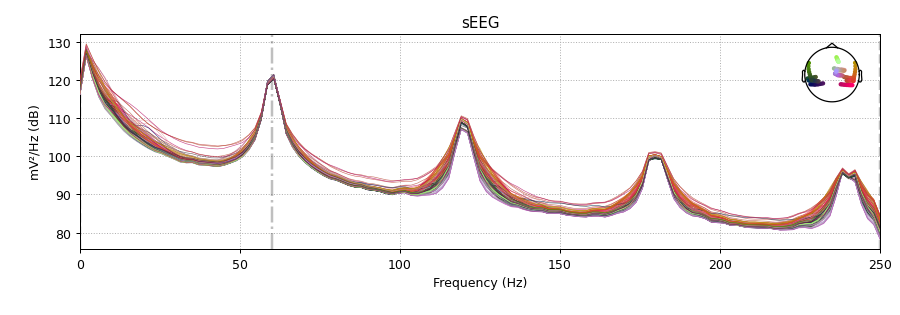

<IPython.core.display.Javascript object>


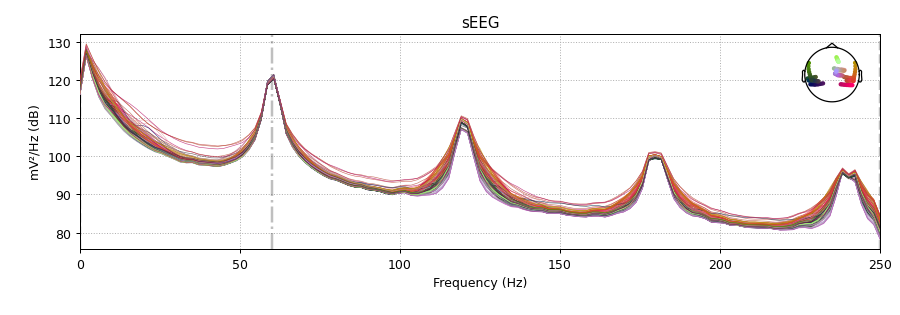

In [51]:
mne_data.compute_psd().plot()

In [49]:
mne_data.info['bads'] = ['lam1', 'rip10', 'rsm4', 'rac3', 'rac6', 'rfp1', 'rtt10']
mne_data.info['bads']

['lam1', 'rip10', 'rsm4', 'rac3', 'rac6', 'rfp1', 'rtt10']

In [52]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 7 items (lam1, rip10, rsm4, rac3, rac6, rfp1, rtt10)
 ch_names: lam1, lam2, lam3, lam4, lam5, lam6, lam7, lam8, lam9, lhb1, ...
 chs: 118 sEEG
 custom_ref_applied: False
 dig: 118 items (118 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 118
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [53]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [54]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=27, n_times=2609728
    Range : 0 ... 2609727 =      0.000 ...  5219.454 secs
Ready.
Added the following bipolar channels:
lam2-lam3, lam8-lam9, lhh1-lhh2, lhh5-lhh6, lhh6-lhh7, lhh7-lhh8, ltt1-ltt2, ltt2-ltt3, ram1-ram2, ram2-ram3, ram3-ram4, ram4-ram5, rhb1-rhb2, rhb7-rhb8, rhb8-rhb9, rhh1-rhh2, rhh2-rhh3, ria3-ria4, ria4-ria5, ria9-ria10, rip1-rip2, rip2-rip3, rip3-rip4, rsm5-rsm6, rtt1-rtt2, rtt2-rtt3, rtt3-rtt4


In [55]:
mne_data_bp_reref

<RawArray | 27 x 2609728 (5219.5 s), ~537.7 MB, data loaded>

In [56]:
mne_data_bp_reref.ch_names

['lam2-lam3',
 'lam8-lam9',
 'lhh1-lhh2',
 'lhh5-lhh6',
 'lhh6-lhh7',
 'lhh7-lhh8',
 'ltt1-ltt2',
 'ltt2-ltt3',
 'ram1-ram2',
 'ram2-ram3',
 'ram3-ram4',
 'ram4-ram5',
 'rhb1-rhb2',
 'rhb7-rhb8',
 'rhb8-rhb9',
 'rhh1-rhh2',
 'rhh2-rhh3',
 'ria3-ria4',
 'ria4-ria5',
 'ria9-ria10',
 'rip1-rip2',
 'rip2-rip3',
 'rip3-rip4',
 'rsm5-rsm6',
 'rtt1-rtt2',
 'rtt2-rtt3',
 'rtt3-rtt4']

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


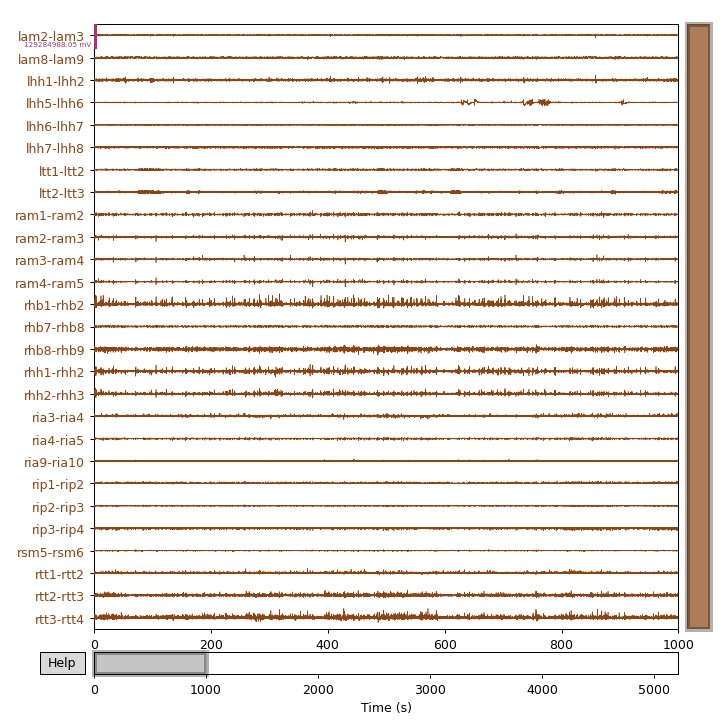

In [57]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=40, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


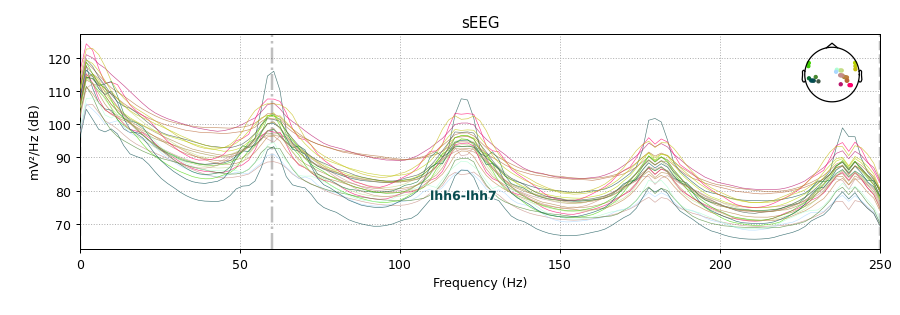

<IPython.core.display.Javascript object>


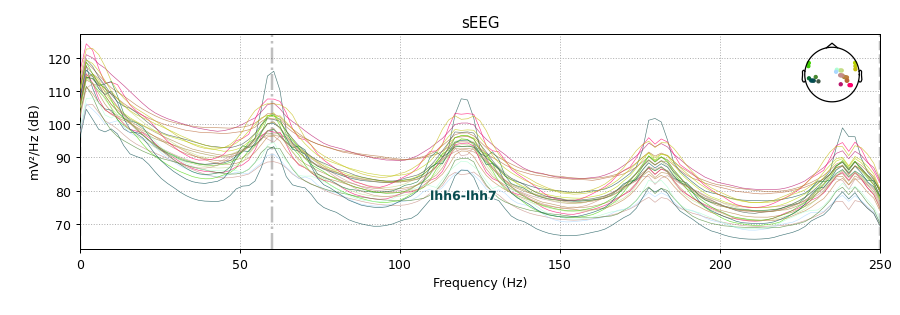

In [58]:
mne_data_bp_reref.compute_psd().plot()

In [59]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/bp_ref_ieeg.fif
[done]


## Save mne_data

In [60]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [61]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [6]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/photodiode.fif...
Isotrak not found
    Range : 0 ... 2609727 =      0.000 ...  5219.454 secs
Ready.
Reading 0 ... 2609727  =      0.000 ...  5219.454 secs...


In [7]:
photodiode_data

<Raw | photodiode.fif, 1 x 2609728 (5219.5 s), ~19.9 MB, data loaded>

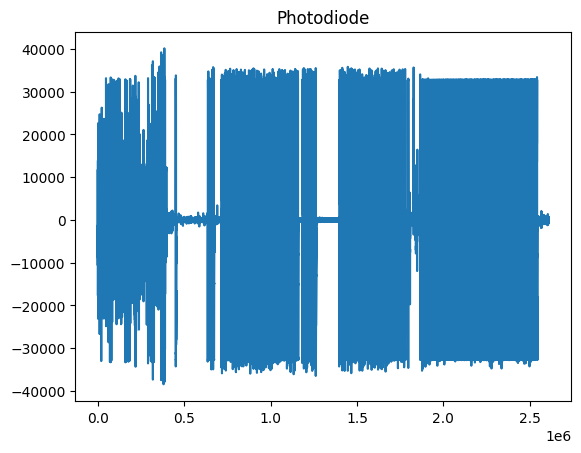

In [126]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,:])
# plt.plot(scipy.stats.zscore(photodiode_data._data[0,:]))
plt.title("Photodiode")
plt.show()

In [137]:
list(zip(bad_peak_indices_start, bad_peak_indices_end))

[(47478, 48578),
 (47480, 48580),
 (47486, 48586),
 (47489, 48589),
 (47492, 48592),
 (47494, 48594),
 (47496, 48596),
 (47500, 48600),
 (47502, 48602),
 (47504, 48604),
 (47511, 48611),
 (47514, 48614),
 (62389, 63489),
 (62406, 63506),
 (62408, 63508),
 (62414, 63514),
 (62416, 63516),
 (74786, 75886),
 (74789, 75889),
 (74792, 75892),
 (74796, 75896),
 (74798, 75898),
 (74800, 75900),
 (74803, 75903),
 (74805, 75905),
 (74807, 75907),
 (74809, 75909),
 (74811, 75911),
 (74813, 75913),
 (74815, 75915),
 (74817, 75917),
 (74819, 75919),
 (74821, 75921),
 (74823, 75923),
 (74825, 75925),
 (74827, 75927),
 (74829, 75929),
 (74831, 75931),
 (74833, 75933),
 (74836, 75936),
 (74839, 75939),
 (74842, 75942),
 (74845, 75945),
 (74848, 75948),
 (74850, 75950),
 (74853, 75953),
 (74867, 75967),
 (74870, 75970),
 (74873, 75973),
 (74875, 75975),
 (74878, 75978),
 (74880, 75980),
 (74882, 75982),
 (74884, 75984),
 (74886, 75986),
 (74888, 75988),
 (74890, 75990),
 (74892, 75992),
 (74894, 75994

In [194]:
temp_diode = photodiode_data.copy()
temp_diode._data[0,temp_diode._data[0,:]<0] = 0
temp_diode._data[0,0:500000] = 0 #np.min(temp_data)
temp_diode._data[0,1850000:] = 0
# temp_diode._data[0,-50000:] = 0 #np.min(temp_data)


In [195]:
bad_peak_indices_start = scipy.signal.find_peaks(photodiode_data._data[0, :], height=25000)[0]- 100
bad_peak_indices_end = scipy.signal.find_peaks(photodiode_data._data[0, :], height=25000)[0] + 1000

In [196]:
# temp_diode = photodiode_data.copy()
for (a,b) in zip(bad_peak_indices_start, bad_peak_indices_end):
    temp_diode._data[0,a:b] = 0

In [197]:
np.max(temp_diode._data[0,:])

24799.0

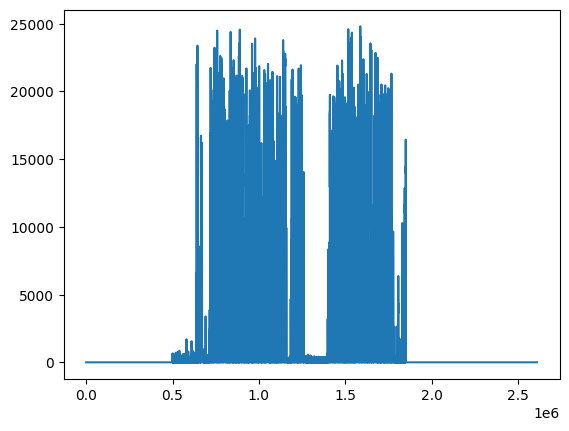

In [198]:
plt.plot(temp_diode._data[0,:])
# 

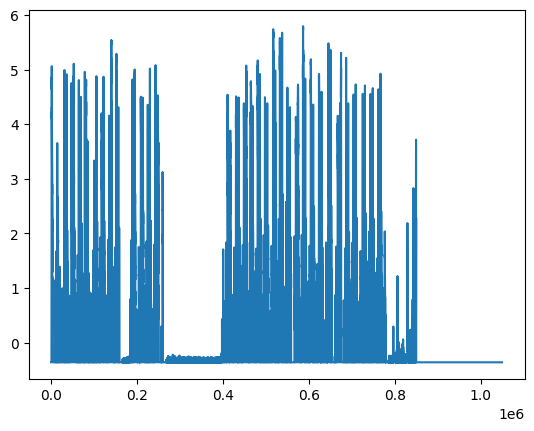

In [226]:
# plt.plot(temp_diode._data[0,:])
plt.plot(scipy.stats.zscore(temp_diode._data[0,1000000:2050000]))
# plt.plot(temp_diode._data[0,2000000:2100000])

# plt.title("Photodiode")
# plt.show()

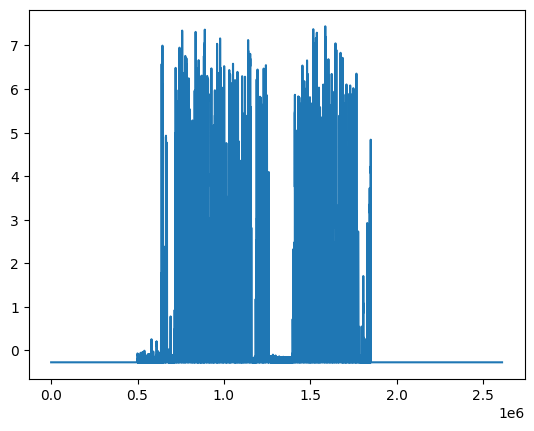

In [201]:
plt.plot(scipy.stats.zscore(temp_diode._data[0,:]))


In [554]:
### Photodiode alignment
smoothSize=15
windSize=15
height=3.15

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

11 blocks
...........

found matches for 15 of 170 pulses


In [555]:
print(slope, offset,smoothSize,windSize,height)

0.9901213028870198 700.5780142549429 15 15 3.15


In [412]:
# print(slope, offset,smoothSize,windSize,height)

1.0190156551565006 824.5840247465738 15 10 3.46


In [327]:
# print(slope, offset,smoothSize,windSize,height)

0.9901213028870198 700.5780142549429 15 10 3.15


In [496]:
[(x*slope + offset) for x in beh_ts]

[1218.6209290940983,
 1228.2094985490266,
 1238.1709844201314,
 1254.5645071903468,
 1263.350945317602,
 1272.3289776597073,
 1294.430832915797,
 1303.1264037496423,
 1312.6837536897253,
 1327.8659876031234,
 1339.432941206166,
 1351.540497476095,
 1367.8652103802406,
 1377.707755454498,
 1387.5982035875113,
 1402.800924694906,
 1412.546408672912,
 1421.1708101815802,
 1436.9935578233622,
 1447.3075748991114,
 1457.1635701772568,
 1473.0836840706365,
 1482.9890489751979,
 1492.4785646157243,
 1507.8215587823588,
 1518.1099730044975,
 1529.2005159799164,
 1542.95352395133,
 1552.2939294029184,
 1562.3003316318336,
 1579.8847430966193,
 1589.275056008461,
 1600.0453223668192,
 1619.588501795438,
 1628.8944878581678,
 1638.7900728395525,
 1657.327598536348,
 1667.76751894194,
 1677.5194725706087,
 1693.8958039636345,
 1703.5686885842692,
 1713.247038476476,
 1728.6008627879974,
 1737.8275006284925,
 1747.8598588873826,
 1765.6470217488682,
 1775.2922370336623,
 1784.2009072199785,
 1800.9

In [837]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [497]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [498]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [499]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [500]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/bp_ref_ieeg.fif...
    Range : 0 ... 2609727 =      0.000 ...  5219.454 secs
Ready.
Reading 0 ... 2609727  =      0.000 ...  5219.454 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    3.0s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
151 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 151 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 27 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/DA11/bp_ref_ieeg.fif...
    Range : 0 ... 2609727 =      0.000 ...  5219.454 secs
Ready.
Reading 0 ... 2609727  =      0.000 ...  5219.454 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    2.7s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
151 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 151 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 27 columns


In [501]:
epochs_all_evs 


{'TrialOnset': <Epochs |  151 events (all good), -2 - 1 sec, baseline off, ~46.8 MB, data loaded, with metadata,
  'TrialOnset': 151>,
 'DecisionOnset': <Epochs |  151 events (all good), -1 - 6 sec, baseline off, ~109.0 MB, data loaded, with metadata,
  'DecisionOnset': 151>}

### Add behavioral data to metadata 

In [502]:
behav_df.columns

Index(['Round', 'Trial Num', 'TrialType', 'TrialOnset', 'ChoiceOnset',
       'DecisionOnset', 'FeedbackOnset', 'RT', 'SafeBet', 'LowBet', 'HighBet',
       'HighBetPos', 'GamblePos', 'ChoicePos', 'GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegr

In [503]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE', 'util_safe_mle', 'util_gamble_mle', 'wSafe_mle', 'wHigh_mle',
       'wLow_mle', 'p_safe_mle', 'p_gamble_mle', 'util_safe_emmap',
       'util_gamble_emmap', 'wSafe_emmap', 'wHigh_emmap', 'wLow_emmap',
       'p_safe_emmap', 'p_gamble_emmap', 'util_tCPE_mle', 'util_dCPE_mle',
       'util_tCF_mle', 'util_dCF_mle', 'util_tRegret_mle', 'util_dRegret_mle',
       'util_tRelief_mle', 'util_dRelief_mle', 'util_RPE_mle', 'util_pRPE_mle',
       'util_nRPE_mle', 'util_tCPE_emmap', 'util_dCPE_emmap', 'util_tCF_emmap',
       'util_dCF_emmap', 'util_tRegret_emmap', 'util_dRegret_emmap',
       'util_tRelief_emmap', 'util_dRelief_emmap', 'util_RPE_emmap',
       'util_pRPE_emmap', 'util_nRPE_emmap']

In [504]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 85 columns
Replacing existing metadata with 85 columns


In [505]:
epochs_all_evs[event].metadata

,lam2-lam3,lam8-lam9,lhh1-lhh2,lhh5-lhh6,lhh6-lhh7,lhh7-lhh8,ltt1-ltt2,ltt2-ltt3,ram1-ram2,ram2-ram3,...,util_dCPE_emmap,util_tCF_emmap,util_dCF_emmap,util_tRegret_emmap,util_dRegret_emmap,util_tRelief_emmap,util_dRelief_emmap,util_RPE_emmap,util_pRPE_emmap,util_nRPE_emmap
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.243440,-0.095676,0.000000,0.000000,0.000000,0.339116,0.243440,0.095676,0.095676,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.976211,0.000000,0.588357,0.000000,0.000000,1.564568,0.976211,0.000000,0.000000,0.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.286459,0.243440,0.286459,-0.243440,-0.286459,0.000000,0.000000,-0.243440,0.000000,-0.243440
3,NaN,NaN,NaN,NaN,noise,NaN,NaN,noise,NaN,NaN,...,-0.013120,0.500000,0.500000,-0.013120,-0.013120,0.000000,0.000000,0.000000,0.000000,0.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.619903,0.619903,0.619903,-0.619903,-0.619903,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,NaN,NaN,NaN,noise,NaN,NaN,NaN,noise,NaN,NaN,...,-0.073897,0.000000,0.000000,-0.073897,-0.073897,0.000000,0.000000,0.000000,0.000000,0.000000
147,NaN,noise,noise,noise,noise,NaN,NaN,noise,NaN,NaN,...,-0.588357,0.672315,0.588357,-0.672315,-0.588357,0.000000,0.000000,-0.672315,0.000000,-0.672315
148,NaN,NaN,NaN,noise,NaN,noise,noise,NaN,NaN,NaN,...,0.761757,-0.299385,0.000000,0.000000,0.000000,1.061141,0.761757,0.299385,0.299385,0.000000
149,NaN,NaN,NaN,noise,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.188025,0.243440,0.188025,-0.243440,-0.188025,0.000000,0.000000,-0.243440,0.000000,-0.243440


### Save raw epoched data 

In [506]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

### Baseline + Decompose into TFRs

In [507]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [508]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = 3
sr = 500.0 
buf = 1.0
buf_ix = int(buf*sr)

In [509]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [510]:
#baseline epoch - 
event = 'TrialOnset'
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


Not setting metadata


In [511]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 151, channels : 27, ~467.6 MB>}

In [512]:
power_epochs = {}

In [513]:
event = 'DecisionOnset'

epochs = epochs_all_evs[event]

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0] 
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'], 
                                                  mode='zscore', 
                                                  trialwise=False, ## make sure this is FALSE!
                                                  baseline_only=True)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



Not setting metadata
Not setting metadata
Adding metadata with 85 columns


In [514]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 151, channels : 27, ~2.28 GB>

In [515]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [516]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

01312024


In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

700.5780142549429


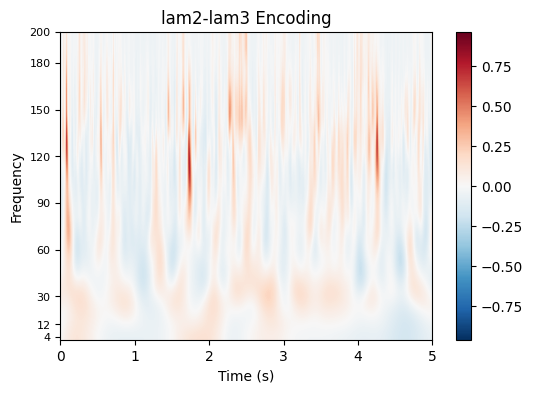

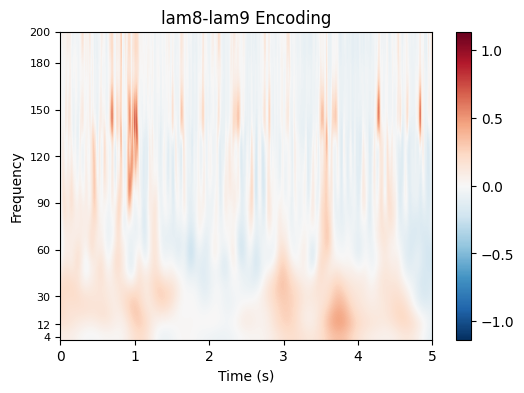

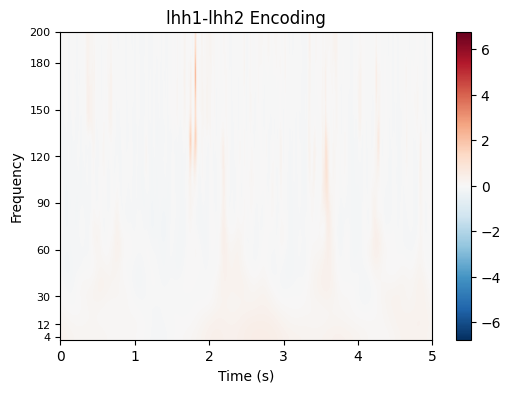

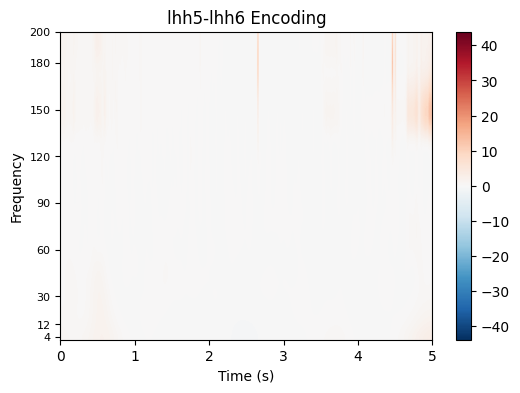

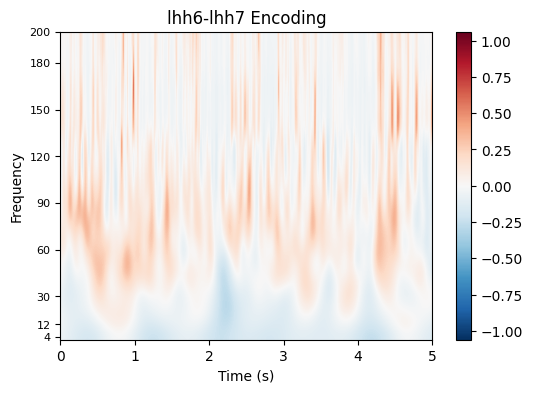

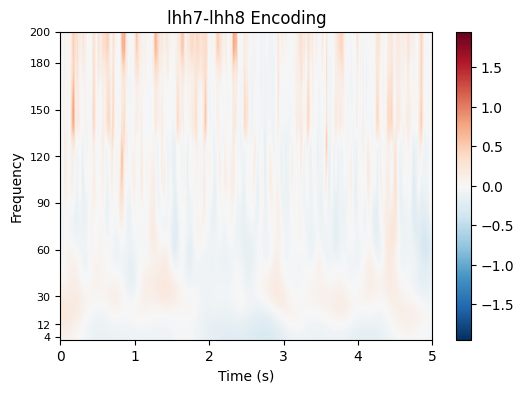

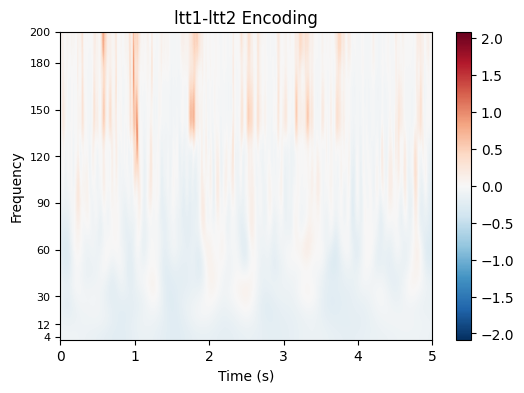

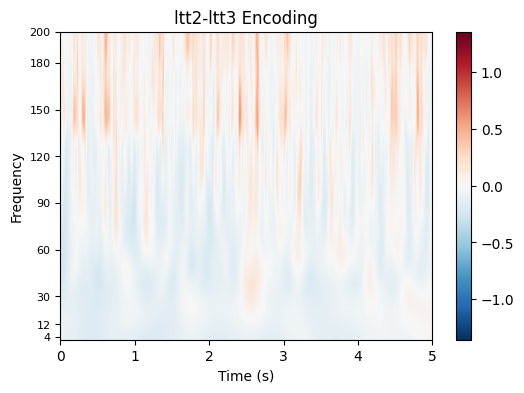

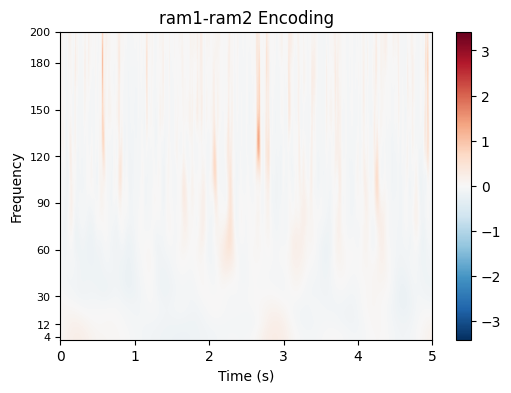

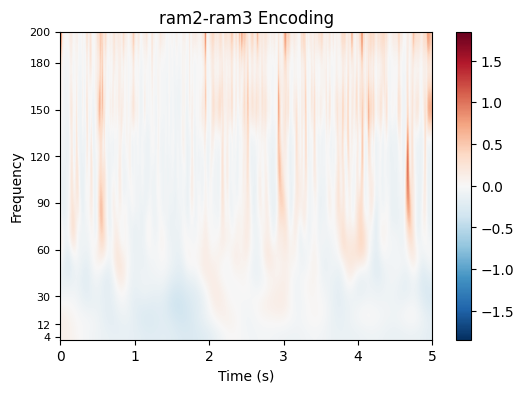

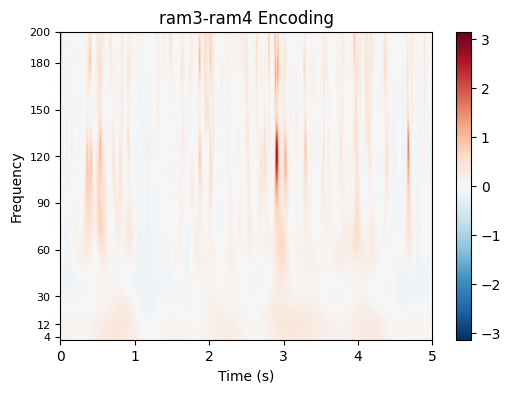

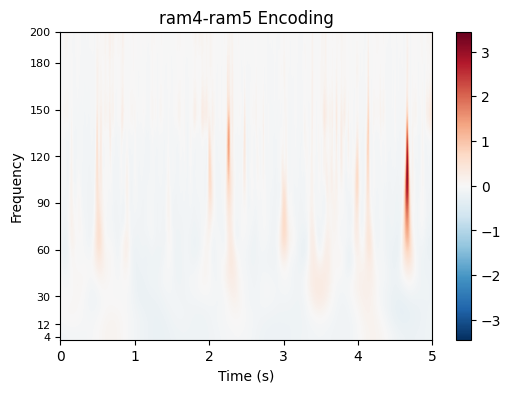

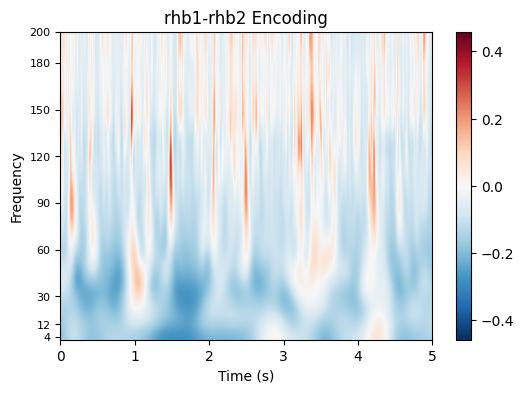

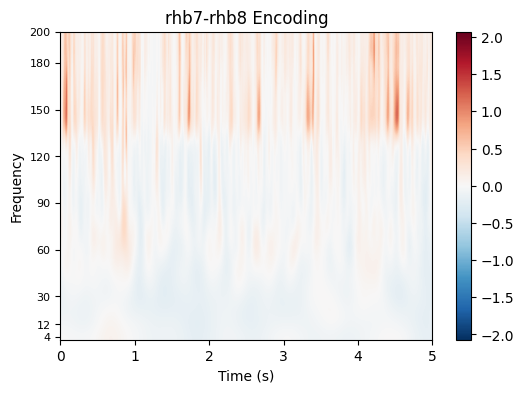

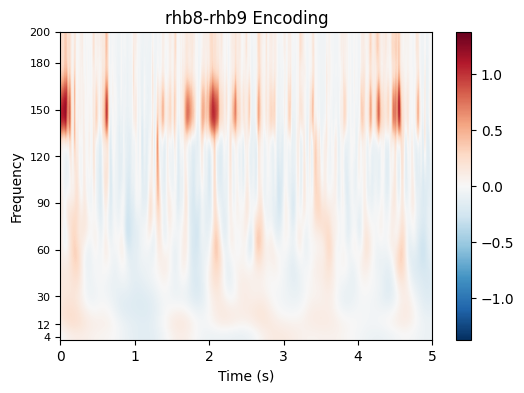

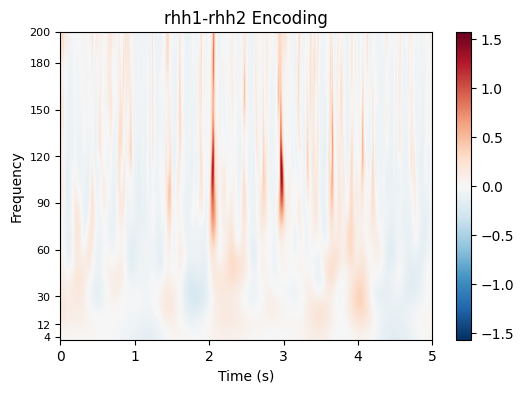

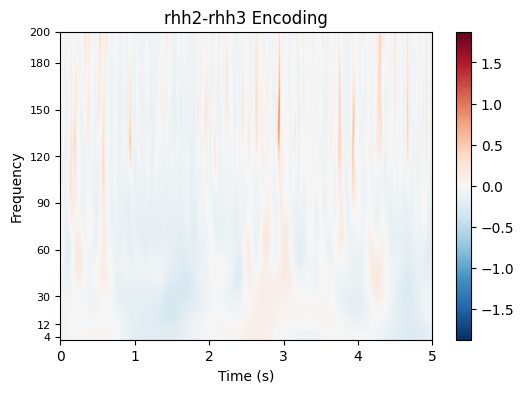

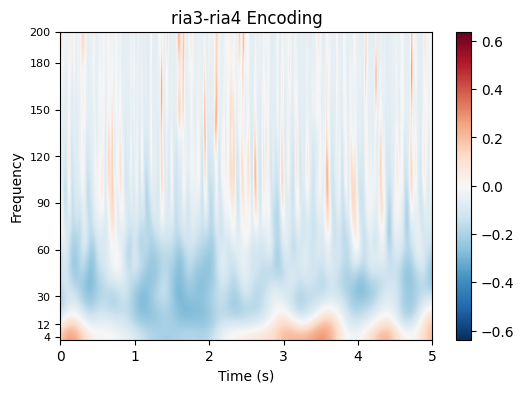

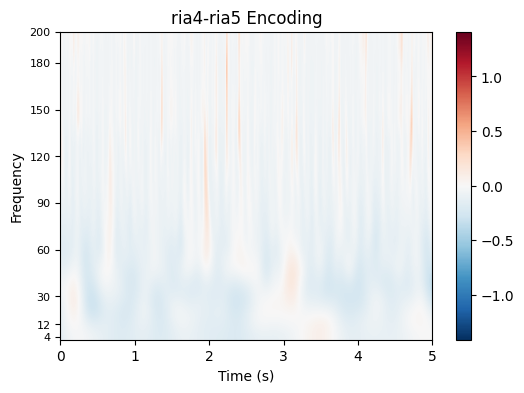

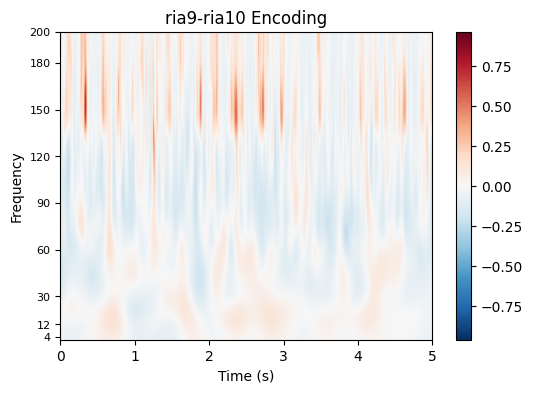

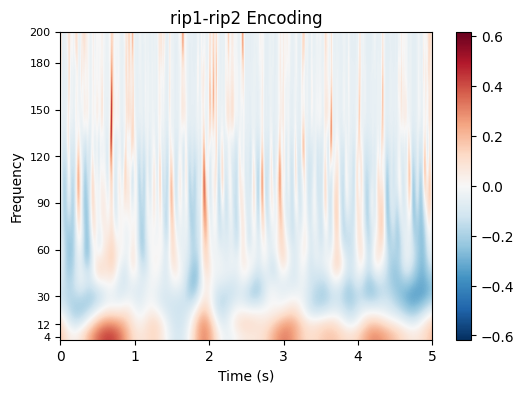

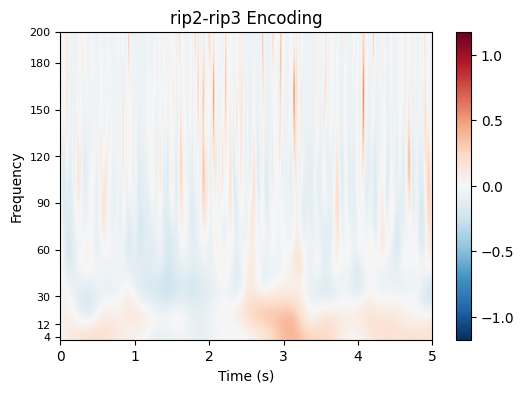

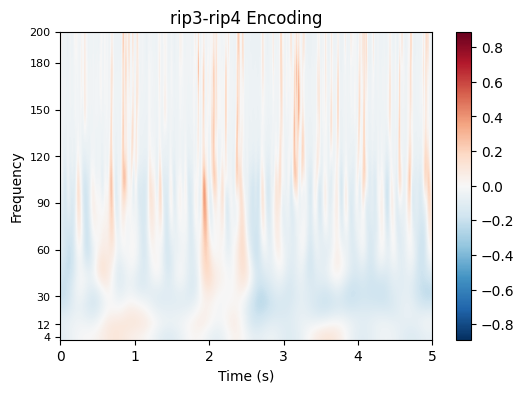

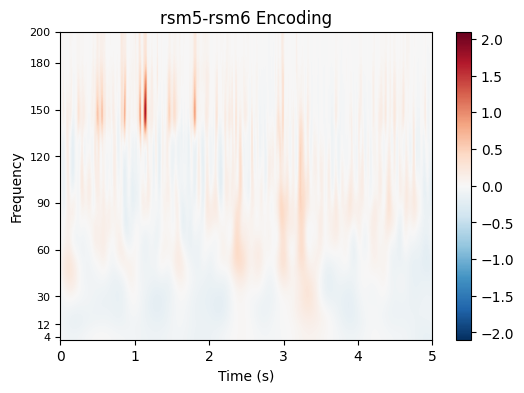

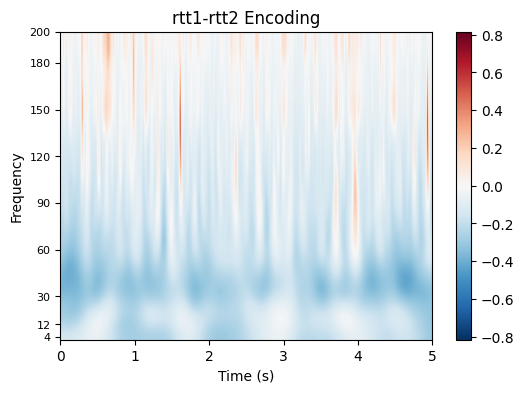

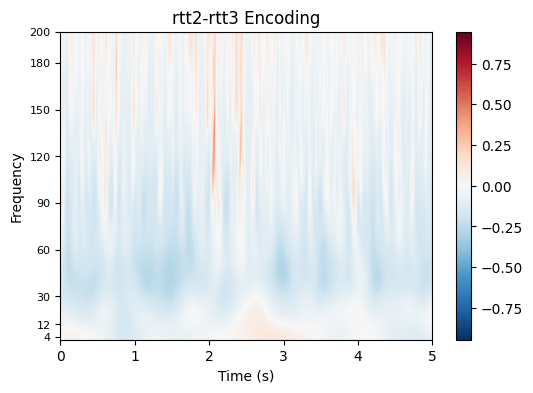

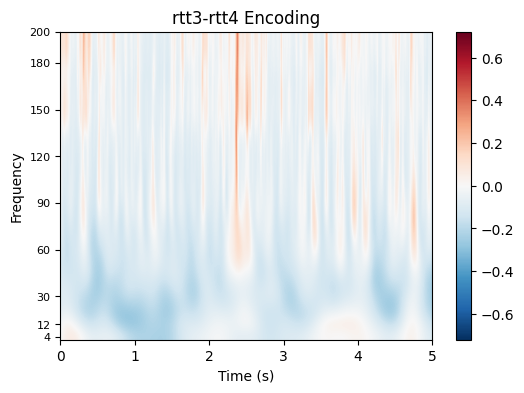

In [517]:
event = 'DecisionOnset'
yticks = [4, 12, 30, 60, 90, 120, 150, 180, 200]
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    times = power_epochs[event].times
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,
            extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
    ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding')
    ax.yaxis.set_tick_params(labelsize=8)
    fig.colorbar(im, ax=ax)
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
#     plt.close()
